<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/DBSCAN%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Moons] eps≈1.113, min_samples=10, clusters=1, noise=24 / 650


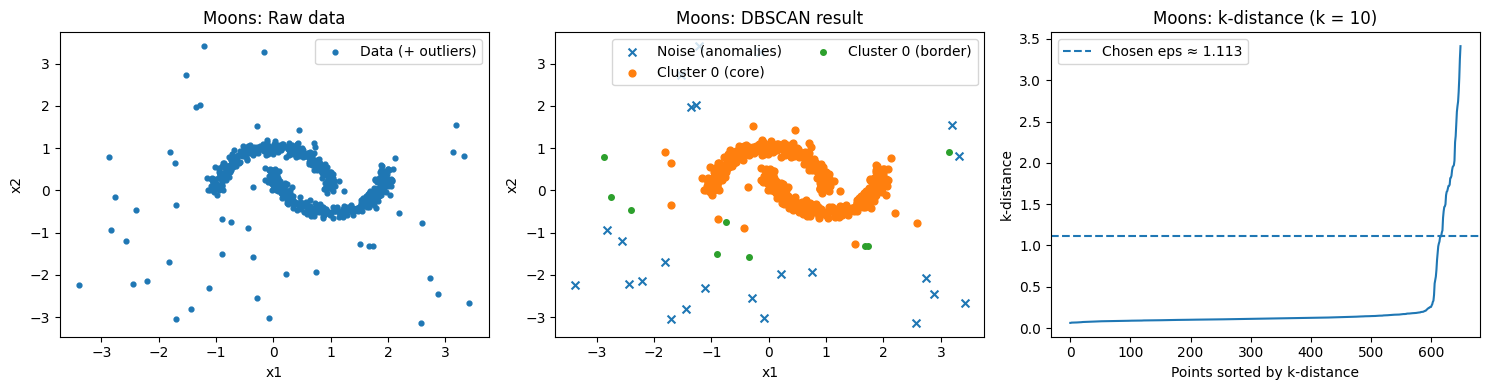

Saved: dbscan_moons.csv

[Concentric Circles] eps≈1.467, min_samples=10, clusters=1, noise=27 / 675


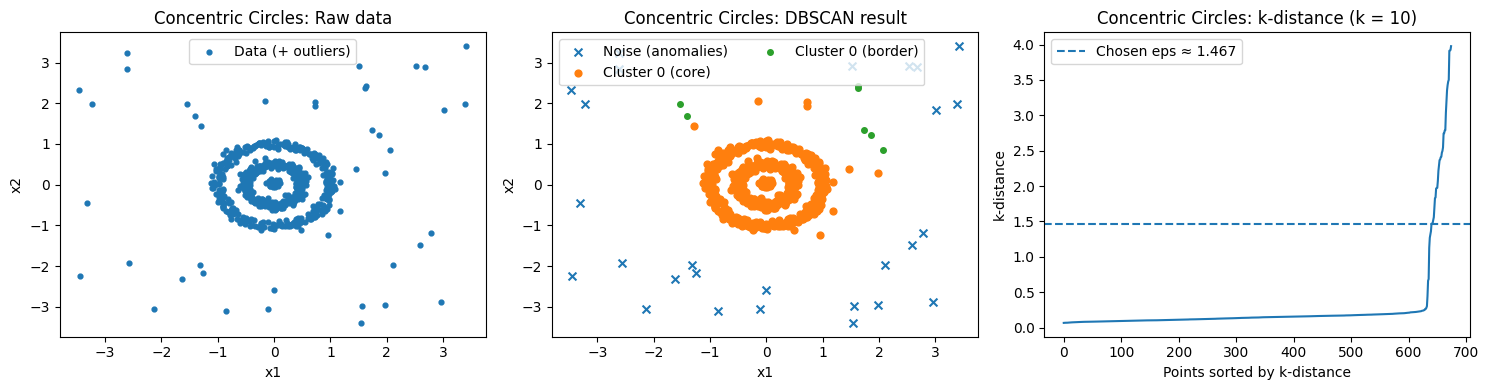

Saved: dbscan_concentric_circles.csv

[Spiral] eps≈1.822, min_samples=10, clusters=1, noise=24 / 650


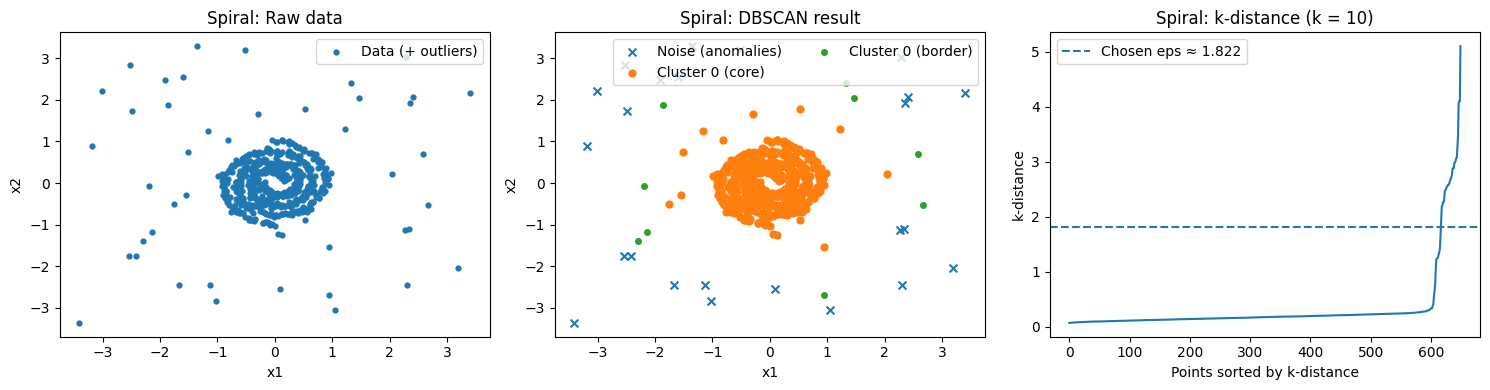

Saved: dbscan_spiral.csv



In [3]:
# Colab-ready: DBSCAN anomaly detection on topological datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If scikit-learn is missing:
# !pip -q install scikit-learn

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles

# ===================== Parameters =====================
SEED = 7
MIN_SAMPLES = 10                     # DBSCAN min_samples (k for k-distance)
AUTO_EPS_PERCENTILE = 95             # percentile for automatic eps (heuristic)
SHOW_DATASETS = ["moons", "circles", "spiral"]  # choose subset if you like
POINTS_PER_SET = 600                 # base samples (before injecting anomalies)
N_OUTLIERS = 50                      # injected anomalies per dataset
RANDOM_OUTLIERS_RANGE = [-3.5, 3.5]  # uniform box for random outliers

rng = np.random.default_rng(SEED)

# ===================== Generators =====================
def gen_moons(n=600, noise=0.08, seed=0):
    X, _ = make_moons(n_samples=n, noise=noise, random_state=seed)
    return X

def gen_circles(n=600, noise=0.06, factor=0.5, seed=0):
    X, _ = make_circles(n_samples=n, noise=noise, factor=factor, random_state=seed)
    return X

def gen_spiral(n=600, noise=0.04, turns=3.5, seed=0):
    # 2-arm spiral
    rng = np.random.default_rng(seed)
    m = n // 2
    t1 = np.linspace(0.3, turns*np.pi, m)
    t2 = t1 + np.pi
    r1 = np.linspace(0.2, 1.0, m)
    r2 = r1
    x1 = r1*np.cos(t1) + rng.normal(0, noise, m)
    y1 = r1*np.sin(t1) + rng.normal(0, noise, m)
    x2 = r2*np.cos(t2) + rng.normal(0, noise, m)
    y2 = r2*np.sin(t2) + rng.normal(0, noise, m)
    X = np.vstack([np.c_[x1, y1], np.c_[x2, y2]])
    return X

def inject_outliers(X, n_out=N_OUTLIERS, seed=0, kind="generic"):
    rng = np.random.default_rng(seed)
    lo, hi = RANDOM_OUTLIERS_RANGE
    uni = rng.uniform(lo, hi, size=(n_out, 2))
    # For circles: also put points in the central "hole" to show topological noise
    if kind == "circles":
        r = rng.uniform(0.0, 0.15, size=(n_out//2,))
        ang = rng.uniform(0, 2*np.pi, size=(n_out//2,))
        hole = np.c_[r*np.cos(ang), r*np.sin(ang)]
        return np.vstack([X, uni, hole])
    return np.vstack([X, uni])

# ===================== DBSCAN & plotting =====================
def auto_eps(X_scaled, min_samples=MIN_SAMPLES, pct=AUTO_EPS_PERCENTILE):
    nn = NearestNeighbors(n_neighbors=min_samples)
    nn.fit(X_scaled)
    dists, _ = nn.kneighbors(X_scaled)
    k_dists = np.sort(dists[:, -1])
    eps = np.percentile(k_dists, pct)
    return eps, k_dists

def run_dbscan(X, title):
    # scale because DBSCAN is distance-based
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    eps, k_dists = auto_eps(Xs)
    db = DBSCAN(eps=eps, min_samples=MIN_SAMPLES)
    labels = db.fit_predict(Xs)

    # core / noise / border masks
    core_idx = getattr(db, "core_sample_indices_", None)
    is_core = np.zeros(len(Xs), dtype=bool)
    if core_idx is not None:
        is_core[core_idx] = True
    is_noise = labels == -1
    is_border = (~is_core) & (~is_noise)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"[{title}] eps≈{eps:.3f}, min_samples={MIN_SAMPLES}, clusters={n_clusters}, noise={is_noise.sum()} / {len(X)}")

    # === plots ===
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    # (A) raw data
    axes[0].scatter(X[:,0], X[:,1], s=12, label="Data (+ outliers)")
    axes[0].set_title(f"{title}: Raw data")
    axes[0].legend(loc="best")
    axes[0].set_xlabel("x1"); axes[0].set_ylabel("x2")

    # (B) DBSCAN result
    uniq = sorted(set(labels))
    for lab in uniq:
        m = labels == lab
        if lab == -1:
            axes[1].scatter(X[m,0], X[m,1], s=32, marker="x", label="Noise (anomalies)")
        else:
            m_core = m & is_core
            if m_core.any():
                axes[1].scatter(X[m_core,0], X[m_core,1], s=24, label=f"Cluster {lab} (core)")
            m_border = m & is_border
            if m_border.any():
                axes[1].scatter(X[m_border,0], X[m_border,1], s=16, marker="o", label=f"Cluster {lab} (border)")
    axes[1].set_title(f"{title}: DBSCAN result")
    axes[1].legend(loc="best", ncol=2)
    axes[1].set_xlabel("x1"); axes[1].set_ylabel("x2")

    # (C) k-distance plot
    axes[2].plot(np.arange(len(k_dists)), k_dists)
    axes[2].axhline(eps, linestyle="--", label=f"Chosen eps ≈ {eps:.3f}")
    axes[2].set_title(f"{title}: k-distance (k = {MIN_SAMPLES})")
    axes[2].set_xlabel("Points sorted by k-distance")
    axes[2].set_ylabel("k-distance")
    axes[2].legend(loc="best")

    plt.tight_layout()
    plt.show()

    # Save CSV
    out = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "label": labels,
                        "is_core": is_core.astype(int), "is_noise": is_noise.astype(int)})
    fname = f"dbscan_{title.lower().replace(' ', '_')}.csv"
    out.to_csv(fname, index=False)
    print(f"Saved: {fname}\n")
    return out

# ===================== Build datasets and run =====================
outputs = {}

if "moons" in SHOW_DATASETS:
    X = gen_moons(n=POINTS_PER_SET, noise=0.08, seed=SEED)
    X = inject_outliers(X, n_out=N_OUTLIERS, seed=SEED+1, kind="generic")
    outputs["moons"] = run_dbscan(X, "Moons")

if "circles" in SHOW_DATASETS:
    X = gen_circles(n=POINTS_PER_SET, noise=0.06, factor=0.5, seed=SEED)
    X = inject_outliers(X, n_out=N_OUTLIERS, seed=SEED+2, kind="circles")
    outputs["circles"] = run_dbscan(X, "Concentric Circles")

if "spiral" in SHOW_DATASETS:
    X = gen_spiral(n=POINTS_PER_SET, noise=0.04, turns=3.5, seed=SEED)
    X = inject_outliers(X, n_out=N_OUTLIERS, seed=SEED+3, kind="generic")
    outputs["spiral"] = run_dbscan(X, "Spiral")
